# Optimized Outcomes


This section of the notebook calculates the optimal outcome for ecosystem services produced by fallowed land to meet SGMA targets by ranking parcels within each crop type by a weighted average ecosystem services metric and selecting the top ranked parcels by crop type to meet fallowing targets set by the [PPIC.](https://www.ppic.org/publication/water-and-the-future-of-the-san-joaquin-valley/) 

Weights may be adjusted before running the notebook. By default, all ecosystem services are equally weighted.

In [1]:
region_code = 'KR'

In [2]:
import pandas as pd
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Input from 010-data-prep
df = pd.read_csv('../outputs/df_' + region_code +'.csv')
trials = pd.read_csv('../outputs/trials_' + region_code +'.csv')

In [4]:
# Path to output, use as input to future notebooks
out_name = '../outputs/' + 'optimal_' + region_code +'.csv'

In [5]:
df.head()

,FID,Area,Crop,FieldCropPrice,SavedWater,Recharge,Kitfox,TiptonKRat,GiantGarterSnake,TNC,...,TiptonKRat_Total,GiantGarterSnake_Total,TNC_Total,HabCorridors_Total,ConservationAreas_Total,ImpBirdAreas_Total,Nitrate_Total,ModSAGBI_Total,Prox2Wetlands_Total,Depth2GroundWater_Norm_Total
0,45,70.791382,AlfalfaandAlfalfaMixtures,78836.822440,359.620220,12283.604020,100.0,100.0,0.0,94.0,...,70.791382,0.000000,66.543899,0.00000,70.791382,0.000000,0.000000,29.732380,0.000000,70.791382
1,72,81.343317,AlfalfaandAlfalfaMixtures,90587.985160,413.224051,1975.754272,100.0,100.0,100.0,0.0,...,81.343317,81.343317,0.000000,0.00000,81.343317,0.000000,81.343317,0.000000,81.343317,20.335829
2,91,28.286742,AlfalfaandAlfalfaMixtures,31501.529700,143.696647,3311.302980,100.0,100.0,0.0,0.0,...,28.286742,0.000000,0.000000,0.00000,13.011901,25.740935,26.400959,27.721007,0.000000,28.286742
3,116,6.073612,AlfalfaandAlfalfaMixtures,6763.878538,30.853951,417.364790,100.0,100.0,0.0,0.0,...,6.073612,0.000000,0.000000,0.00000,6.073612,0.000000,5.061344,4.585577,0.000000,3.492327
4,143,97.932855,AlfalfaandAlfalfaMixtures,109062.924200,497.498904,11437.290070,100.0,100.0,4.0,0.0,...,97.932855,3.917314,0.000000,81.28427,97.932855,0.000000,0.000000,94.994870,97.932855,97.932855


In [6]:
targets = pd.read_csv('../data/targets.csv', index_col='region', thousands=',')
targets

,alfalfa-pasture,corn,field-crops-grains,veg-fruits,trees-vines
region,,,,,
NW,21320.0,8400.0,85920.0,3880.0,3880.0
NE,56850.0,7750.0,23580.0,2260.0,16800.0
SW,36820.0,3880.0,72350.0,8400.0,7750.0
SE,38760.0,16150.0,124030.0,650.0,9690.0
KR,88500.0,54910.0,42640.0,3230.0,11630.0


In [7]:
eco_services = ['SavedWater_Norm', 'Recharge_Norm', 'Kitfox',
                'TiptonKRat', 'GiantGarterSnake', 'TNC', 'HabCorridors',
                'ConservationAreas', 'ImpBirdAreas', 'Nitrate', 'ModSAGBI',
                'Prox2Wetlands', 'Depth2GroundWater_Norm']
crop_types = targets.columns

In [8]:
# Create weights table with equal weights
# weight_vals = [1/len(eco_services)] * len(eco_services)
# out = OrderedDict(list(zip(eco_services, weight_vals)))
# out_df = pd.DataFrame(weight_vals, index = eco_services, columns = ['weights'])
# out_df.to_csv('../data/weights.csv')

In [9]:
weight_table = pd.read_csv('../data/weights.csv', index_col=0)
weight_table

,weights
SavedWater_Norm,0.0
Recharge_Norm,0.0
Kitfox,0.2
TiptonKRat,0.2
GiantGarterSnake,0.0
TNC,0.2
HabCorridors,0.2
ConservationAreas,0.2
ImpBirdAreas,0.0
Nitrate,0.0


In [10]:
weights = np.array(weight_table['weights'])
weights

array([0. , 0. , 0.2, 0.2, 0. , 0.2, 0.2, 0.2, 0. , 0. , 0. , 0. , 0. ])

In [11]:
weights.shape[0] == df[eco_services].shape[1]

True

In [12]:
weight_table.index.values == df[eco_services].columns.values

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [13]:
df['outcome'] = pd.Series(np.average(df[eco_services], weights=weights, axis=1))
df.head()

,FID,Area,Crop,FieldCropPrice,SavedWater,Recharge,Kitfox,TiptonKRat,GiantGarterSnake,TNC,...,GiantGarterSnake_Total,TNC_Total,HabCorridors_Total,ConservationAreas_Total,ImpBirdAreas_Total,Nitrate_Total,ModSAGBI_Total,Prox2Wetlands_Total,Depth2GroundWater_Norm_Total,outcome
0,45,70.791382,AlfalfaandAlfalfaMixtures,78836.822440,359.620220,12283.604020,100.0,100.0,0.0,94.0,...,0.000000,66.543899,0.00000,70.791382,0.000000,0.000000,29.732380,0.000000,70.791382,78.8
1,72,81.343317,AlfalfaandAlfalfaMixtures,90587.985160,413.224051,1975.754272,100.0,100.0,100.0,0.0,...,81.343317,0.000000,0.00000,81.343317,0.000000,81.343317,0.000000,81.343317,20.335829,60.0
2,91,28.286742,AlfalfaandAlfalfaMixtures,31501.529700,143.696647,3311.302980,100.0,100.0,0.0,0.0,...,0.000000,0.000000,0.00000,13.011901,25.740935,26.400959,27.721007,0.000000,28.286742,49.2
3,116,6.073612,AlfalfaandAlfalfaMixtures,6763.878538,30.853951,417.364790,100.0,100.0,0.0,0.0,...,0.000000,0.000000,0.00000,6.073612,0.000000,5.061344,4.585577,0.000000,3.492327,60.0
4,143,97.932855,AlfalfaandAlfalfaMixtures,109062.924200,497.498904,11437.290070,100.0,100.0,4.0,0.0,...,3.917314,0.000000,81.28427,97.932855,0.000000,0.000000,94.994870,97.932855,97.932855,76.6


In [14]:
#Get list of columns to track for each repetition
outcome_cols = ['Area', 'FieldCropPrice', 'SavedWater_Norm', 'Recharge_Norm', 'Kitfox_Total',
                'TiptonKRat_Total', 'GiantGarterSnake_Total', 'TNC_Total', 'HabCorridors_Total',
                'ConservationAreas_Total', 'ImpBirdAreas_Total', 'Nitrate_Total', 'ModSAGBI_Total',
                'Prox2Wetlands_Total', 'Depth2GroundWater_Norm_Total'] 

In [15]:
df_optimal = pd.DataFrame(columns=df.columns)
for crop in crop_types:
    df_crop = df[df['Crop_PPIC'] == crop]
    target = targets.loc[region_code, crop]
    df_crop_sorted = df_crop.sort_values(['PricePerAcre','outcome'], ascending=[True,False])
    # Identify fields up to target
    df_fallow_bool = df_crop_sorted['Area'].cumsum() < target
    # Get one additional field by updating value from False to True where 
    # first instance of False is located
    if not df_fallow_bool[df_fallow_bool!=True].empty:
        index = df_fallow_bool[df_fallow_bool!=True].index[0]
        df_fallow_bool.at[index]=True        
    df_crop_fallow = df_crop_sorted[df_fallow_bool]
    df_optimal = df_optimal.append(df_crop_fallow, ignore_index=True)
outcomes = pd.DataFrame(df_optimal[outcome_cols].sum()).T
areas = df_optimal[['Area','Crop_PPIC']].groupby('Crop_PPIC').sum().T
areas.reset_index(drop=True, inplace=True)
output = pd.concat([outcomes, areas], axis=1, sort=False)

In [16]:
df_optimal.head(10)

,FID,Area,Crop,FieldCropPrice,SavedWater,Recharge,Kitfox,TiptonKRat,GiantGarterSnake,TNC,...,GiantGarterSnake_Total,TNC_Total,HabCorridors_Total,ConservationAreas_Total,ImpBirdAreas_Total,Nitrate_Total,ModSAGBI_Total,Prox2Wetlands_Total,Depth2GroundWater_Norm_Total,outcome
0,1147,18.954615,MixedPasture,356.536303,87.380774,1302.517872,100.0,100.0,0.0,100.0,...,0.00000,18.954615,0.000000,18.954615,18.954615,18.533401,13.647323,18.954615,9.477307,80.0
1,2807,11.906969,MixedPasture,223.970081,54.891126,1396.546932,100.0,0.0,0.0,100.0,...,0.00000,11.906969,11.906969,11.906969,0.000000,11.642369,10.716272,11.906969,11.906969,80.0
2,2974,49.319529,MixedPasture,927.700341,227.363029,1278.293374,100.0,100.0,0.0,100.0,...,0.00000,49.319529,0.000000,49.319529,49.319529,49.319529,38.715830,49.319529,24.659765,80.0
3,5672,76.002196,MixedPasture,1429.601302,350.370123,2351.678467,100.0,100.0,0.0,100.0,...,0.00000,76.002196,0.000000,76.002196,76.002196,76.002196,47.501372,76.002196,38.001098,80.0
4,6090,33.045659,MixedPasture,621.588841,152.340487,1480.202981,100.0,100.0,41.0,100.0,...,13.54872,33.045659,0.000000,33.045659,33.045659,17.991525,1.817511,33.045659,33.045659,80.0
5,7798,16.917084,MixedPasture,318.210353,77.987758,1148.184416,100.0,100.0,0.0,100.0,...,0.00000,16.917084,0.000000,16.917084,16.917084,15.789279,12.180301,16.917084,6.343907,80.0
6,742,3.977330,MixedPasture,74.813584,18.335493,465.594306,100.0,100.0,0.0,0.0,...,0.00000,0.000000,0.000000,3.977330,0.000000,3.358635,0.000000,0.000000,1.988665,60.0
7,3819,2.907645,MixedPasture,54.692804,13.404244,298.747157,100.0,100.0,0.0,0.0,...,0.00000,0.000000,0.000000,2.907645,0.000000,2.584573,0.000000,0.000000,2.907645,60.0
8,14014,3.378447,MixedPasture,63.548587,15.574640,556.250585,100.0,100.0,0.0,0.0,...,0.00000,0.000000,0.000000,3.378447,0.000000,1.876915,1.858146,3.378447,3.378447,60.0
9,17865,7.646042,MixedPasture,143.822056,35.248255,1258.896643,100.0,100.0,0.0,0.0,...,0.00000,0.000000,0.000000,7.034359,0.000000,6.626570,7.416661,7.646042,5.734532,58.4


In [17]:
df_optimal.to_csv(out_name)

C:\Users\Erik\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


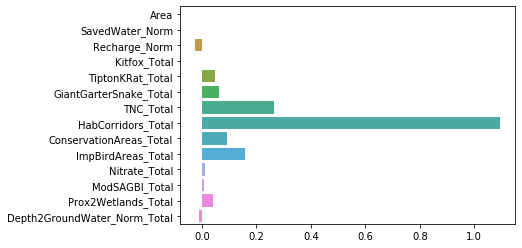

In [18]:
plot_cols = outcome_cols[:1] + outcome_cols[2:] #Exclude FieldCropPrice
optimal = df_optimal[plot_cols].sum()
as_usual = trials[plot_cols].mean()
pct_chg = (optimal - as_usual)/as_usual
sns.barplot(x = pct_chg, y = df_optimal[plot_cols].columns)

In [19]:
optimal_cost = df_optimal['FieldCropPrice'].sum()
print(f'${optimal_cost.sum():,.2f}')

$251,855,405.40


In [20]:
average_cost = trials['FieldCropPrice'].mean()
print(f'${average_cost:,.2f}')

$251,770,570.94


In [21]:
cost = df_optimal['FieldCropPrice'].sum() - trials['FieldCropPrice'].mean()
print (f'The cost of this optimization is ${cost:,.0f}')

The cost of this optimization is $84,834


In [22]:
for crop in crop_types:
    area_diff = df_optimal[df_optimal['Crop_PPIC']==crop]['Area'].sum() - trials[crop].mean()
    print (f'{area_diff:,.2f} acres of {crop}')

-0.00 acres of alfalfa-pasture
0.00 acres of corn
45.65 acres of field-crops-grains
18.00 acres of veg-fruits
-17.26 acres of trees-vines


In [23]:
df.columns

Index(['FID', 'Area', 'Crop', 'FieldCropPrice', 'SavedWater', 'Recharge',
       'Kitfox', 'TiptonKRat', 'GiantGarterSnake', 'TNC', 'HabCorridors',
       'ConservationAreas', 'ImpBirdAreas', 'Nitrate', 'ModSAGBI',
       'Prox2Wetlands', 'Depth2GroundWater', 'Crop_PPIC', 'PricePerAcre',
       'SavedWater_Norm', 'Recharge_Norm', 'Depth2GroundWater_Norm',
       'Kitfox_Total', 'TiptonKRat_Total', 'GiantGarterSnake_Total',
       'TNC_Total', 'HabCorridors_Total', 'ConservationAreas_Total',
       'ImpBirdAreas_Total', 'Nitrate_Total', 'ModSAGBI_Total',
       'Prox2Wetlands_Total', 'Depth2GroundWater_Norm_Total', 'outcome'],
      dtype='object')

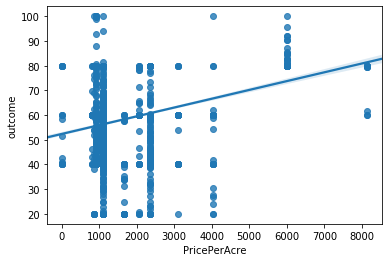

In [24]:
sns.regplot(y=df_optimal['outcome'], x=df_optimal['PricePerAcre'])

C:\Users\Erik\Anaconda3\lib\site-packages\seaborn\distributions.py:214: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)


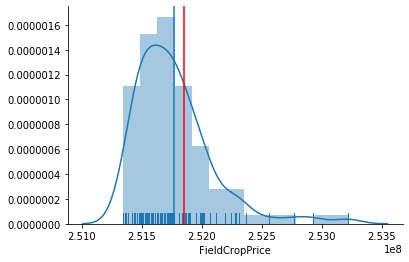

In [25]:
sns.distplot(trials['FieldCropPrice'], rug=True)
plt.axvline(x = df_optimal['FieldCropPrice'].sum(), color='red')
plt.axvline(x = trials['FieldCropPrice'].mean())
sns.despine()

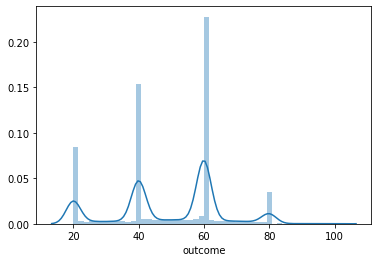

In [26]:
sns.distplot(df.dropna(subset=['outcome'])['outcome'])

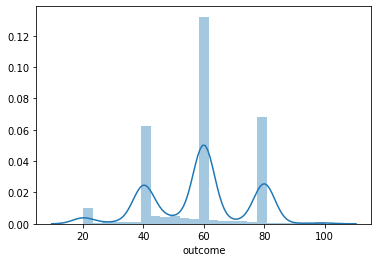

In [27]:
sns.distplot(df_optimal.dropna(subset=['outcome'])['outcome'])

In [28]:
sub_crops = df['Crop'].unique()
sub_crops

array(['AlfalfaandAlfalfaMixtures', 'Almonds', 'Apples', 'Avocados',
       'Beans(Dry)', 'BushBerries', 'Carrots', 'Cherries', 'Citrus',
       'ColeCrops', 'Corn,SorghumandSudan', 'Cotton',
       'Flowers,NurseryandChristmasTreeFarms', 'Grapes', 'Idle', 'Kiwis',
       'Lettuce/LeafyGreens', 'Melons,SquashandCucumbers',
       'MiscellaneousDeciduous', 'MiscellaneousGrainandHay',
       'MiscellaneousGrasses', 'MiscellaneousSubtropicalFruits',
       'MiscellaneousTruckCrops', 'MixedPasture', 'Olives',
       'OnionsandGarlic', 'Peaches/Nectarines', 'Pears', 'Peppers',
       'Pistachios', 'Plums,PrunesandApricots', 'Pomegranates',
       'PotatoesandSweetPotatoes', 'Safflower', 'Strawberries',
       'Tomatoes', 'Walnuts', 'Wheat', 'YoungPerennials'], dtype=object)

In [29]:
len(sub_crops)

39

In [30]:
data = df_optimal[df_optimal['Crop']=='AlfalfaandAlfalfaMixtures']
x = data['PricePerAcre']
y = data['outcome']

In [31]:
df_by_crop = df_optimal.groupby(['Crop']).mean()
df_by_crop

,Area,FieldCropPrice,SavedWater,Recharge,Kitfox,TiptonKRat,GiantGarterSnake,TNC,HabCorridors,ConservationAreas,...,GiantGarterSnake_Total,TNC_Total,HabCorridors_Total,ConservationAreas_Total,ImpBirdAreas_Total,Nitrate_Total,ModSAGBI_Total,Prox2Wetlands_Total,Depth2GroundWater_Norm_Total,outcome
Crop,,,,,,,,,,,,,,,,,,,,,
AlfalfaandAlfalfaMixtures,59.731250,66519.706825,303.434751,4890.834405,100.0,91.839087,26.823721,13.856485,2.948484,70.712023,...,19.800209,9.472087,1.647627,41.982106,14.334714,46.555226,23.221759,33.621886,44.438397,55.871216
Almonds,44.152964,264720.422662,200.454458,4097.180037,100.0,99.553571,39.107143,44.206845,58.944940,100.000000,...,18.695286,22.911517,23.153677,44.152964,15.902458,30.410870,23.274731,31.584387,35.148209,80.541071
Apples,20.140825,33388.452025,73.111193,2217.490898,100.0,10.937500,9.375000,0.000000,0.000000,32.782552,...,5.866978,0.000000,0.000000,9.911534,0.000000,11.426932,1.628798,18.546428,20.140825,28.744010
Beans(Dry),41.481700,85122.521924,135.230341,4667.561069,100.0,73.562500,10.000000,14.975000,5.550000,84.458333,...,7.563756,6.804138,1.382061,34.170262,10.674972,29.265862,20.009453,17.456946,38.496463,55.709167
"Corn,SorghumandSudan",61.503151,145106.229492,208.495682,5569.744025,100.0,88.710276,30.629534,17.879102,0.115285,68.110535,...,24.991581,12.288116,0.010944,38.732476,11.785833,49.977819,25.799243,40.175303,41.224321,54.963040
MiscellaneousGrainandHay,50.058789,42981.477560,93.109348,4206.477943,100.0,84.087156,8.944954,12.036697,7.339450,75.697248,...,7.313996,7.269348,2.713509,32.157959,13.632474,36.326378,16.472467,26.254507,36.323828,55.832110
MiscellaneousGrasses,48.015989,39216.579211,221.353711,2869.417665,100.0,91.566667,33.333333,8.341667,0.000000,93.333333,...,23.878893,6.290628,0.000000,45.495615,8.947979,44.100054,27.159957,32.826872,31.030752,58.648333
MixedPasture,15.354814,288.824051,70.785692,1079.749057,100.0,89.473684,2.157895,31.578947,5.263158,61.429825,...,0.713091,10.849792,0.626683,12.154687,10.223110,13.214129,8.570758,13.526089,9.120978,57.549123
Tomatoes,25.541034,207602.380995,66.917510,1831.531889,100.0,99.551282,15.384615,15.192308,62.230769,100.000000,...,12.126487,5.707946,5.614736,25.541034,5.775516,20.419058,7.849719,18.699150,19.603237,75.394872


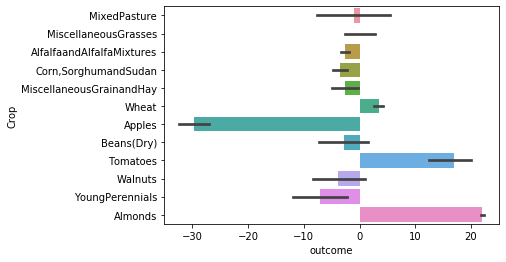

In [32]:
crop_mean_outcome = df_optimal['outcome'].mean()
sns.barplot(data=df_optimal, x='outcome', y='Crop', estimator = (lambda x: np.mean(x)-crop_mean_outcome), ci=90)

# Mapping

In [40]:
import geopandas as gpd
import contextily as ctx

In [41]:
fields = gpd.read_file('../spatial/Kern_Fields.shp')

In [42]:
fields.crs = {'init': 'epsg:6414'}

{'init': 'epsg:6414'}

In [43]:
fields = fields.to_crs(epsg=3857)

{'init': 'epsg:3857', 'no_defs': True}

In [44]:
fields_to_map = fields.set_index('FID_1').join(df_optimal.set_index('FID'), how='inner')
# Alternative from geopandas (have to create new (or could rename) 'FID_1' to 'FID' to have matching column) 
#fields['FID'] = fields['FID_1']
#fields_to_map = fields.merge(df_optimal, on='FID')

In [45]:
plt.rcParams["figure.figsize"] = (20,10)

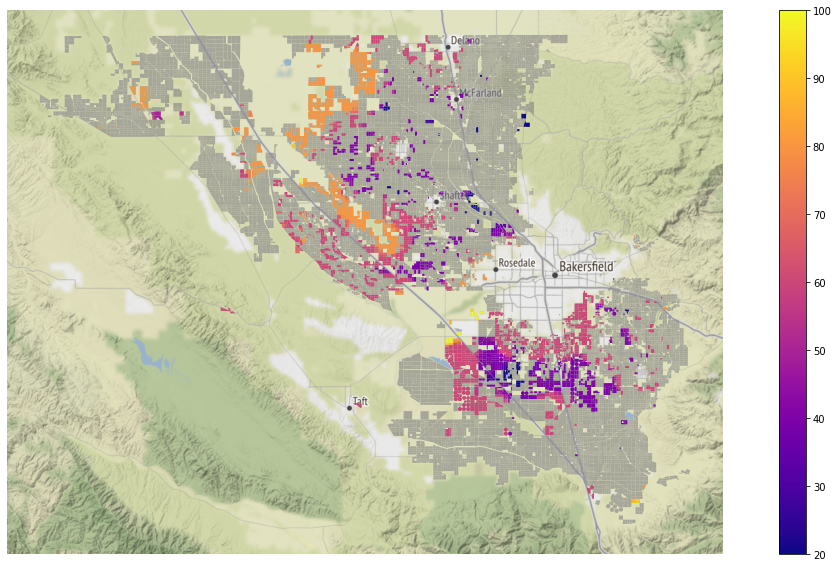

In [54]:
base = fields.plot(color = 'grey', alpha = 0.6)
fields_to_map.plot(ax=base, column='outcome', cmap='plasma', legend=True)
ctx.add_basemap(base, url=ctx.sources.ST_TERRAIN)
base.set_axis_off()